<a href="https://colab.research.google.com/github/borisenko-ru/spe_pivot_2022_datathon/blob/main/spe_pivot_datathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
[![nbviewer](https://raw.githubusercontent.com/jupyter/design/master/logos/Badges/nbviewer_badge.svg)](https://nbviewer.org/github/borisenko-ru/spe_pivot_2022_datathon/blob/main/spe_pivot_datathon.ipynb)


# SPE PIVOT 2022 Geothermal Datathon


In [1]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 70.8 MB/s 


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import catboost
import time

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from catboost import CatBoostClassifier
from scipy import integrate

from google.colab import output
output.enable_custom_widget_manager()
from google.colab import drive
drive.mount('/content/gdrive')

import warnings
warnings.filterwarnings("ignore")
rnd_state = 13


Mounted at /content/gdrive


In [146]:
def base_params_plots(param, title, xlim_hist, ylim_hist, ylim):
  f, ax = plt.subplots(1, 2, figsize=(15,5))
  sns.boxplot(data=pd.DataFrame({'<3000 kJ/s': P_usable_cat1[param], '3000-10000 kJ/s': P_usable_cat2[param],\
                                  '10000-50000 kJ/s': P_usable_cat3[param], '>50000 kJ/s': P_usable_cat4[param]}), ax=ax[0])
  sns.histplot(data=pd.DataFrame({'<3000 kJ/s': P_usable_cat1[param], '3000-10000 kJ/s': P_usable_cat2[param],\
                                  '10000-50000 kJ/s': P_usable_cat3[param], '>50000 kJ/s': P_usable_cat4[param]}), multiple='stack', ax=ax[1])
  ax[0].set(xlabel='P_usable_cum', ylabel=param, ylim=ylim, title=title)
  ax[1].set(xlabel=param, xlim=xlim_hist, ylim=ylim_hist, title=title)

  plt.show()
  

In [3]:
%cd /content/gdrive/My Drive/Colab Notebooks


/content/gdrive/My Drive/Colab Notebooks


In [4]:
inputs_results_main30yr = pd.read_csv('datasets/inputs_results_FORGE_main30yr.csv')


#### Objective functions
* Timeseries without losses
$$P_{usable}=0.13(dhout+(h_{95C}-h_{120C})mpro)$$ \\
* Cumulative without Losses
$$P_{usable}=\frac{1}{20yr} \int^{20}_{0} 0.13(dhout+(h_{95C}-h_{120C})mpro)dt$$ \\
* Timeseries with Losses
$$P_{usable}=0.13(dhout+(h_{95C}-h_{120C}-v5(Pinj-Pwhp))mpro)$$ \\
where: \\
$P_{usable}$ - amount of enthalpy, kJ/s \
$dhout$ - enthalpy-rate change from injection to production, kJ/s \
$h_{95C},h_{120C}$ - reference enthalpies (calculated), kJ/kg \
$v5$ - specific volume (thermodynamic term), m<sup>3</sup>/kg \
$P_{inj}$ - pressure of injected fluid, MPa (x10<sup>3</sup> kJ/m<sup>3</sup>) \
$P_{whp}$ - power plant inlet pressure, MPa (x10<sup>3</sup> kJ/m<sup>3</sup>) \
$mpro$ - production mass flowrate, kg/s


Performance indicators:
* $hpro$ - Production Enthalpy, kJ/kg
* $T0$ - Production Temperature, K
* $dhout$ - Thermal Recovery - enthalpy-rate change from injection to production, kJ/s
* $Pout$ - Electrical Power Output, kW


### Dataset structure
INPUTS:
*	<b>	a	-	Shear displacement-dilation coefficient	</b>	m/m	Scaling
*	<b>	alpha	-	Fracture compressibility	</b>	1/MPa	Scaling
*	<b>	AmbPres	-	Ambient surface pressure	</b>	MPa	Site
*	<b>	AmbTempC	-	Ambient surface temperature	</b>	C	Site
*	<b>	b	-	Shear displacement-dilation exponent	</b>	-	Scaling
*	<b>	bh	-	Default hydraulic aperture	</b>	m	Scaling
*	<b>	bh_bound	-	Boundary hydraulic aperture	</b>	m	Site
*	<b>	bh_max	-	Maximum hydraulic aperture	</b>	m	Solver Setup
*	<b>	bh_min	-	Minimum hydraulic aperture	</b>	m	Solver Setup
*	<b>	BH_P	-	Reservoir pore pressure	</b>	MPa	Site
*	<b>	BH_T	-	Reservoir temperature	</b>	R	Site
*	<b>	bval	-	b-value (Gutenberg Richter)	</b>		Solver Setup
*	<b>	CemKt	-	Cement thermal conductivity	</b>	W/mK	Well
*	<b>	CemSv	-	Cement volumetric specific heat capacity	</b>	kJ/m3K	Well
*	<b>	dE0	-	Initial thermal energy withdraw	</b>	kJ/m2	Solver Setup
*	<b>	dPi	-	Pressure increment	</b>	MPa	Solver Setup
*	<b>	dPp	-	Production well pressure rise	</b>	MPa	Well
*	<b>	dT0	-	Initial temperature gradient	</b>	K	Solver Setup
*	<b>	f_roughness	-	Fracture roughness	</b>	-	Scaling
*	<b>	fDia	-	Fracture set 1 diameter	</b>	m	Fracture
*	<b>	fDia	-	Fracture set 2 diameter	</b>	m	Fracture
*	<b>	fDia	-	Fracture set 3 diameter	</b>	m	Fracture
*	<b>	fDip	-	Fracture set 1 dip	</b>	deg	Fracture
*	<b>	fDip	-	Fracture set 2 dip	</b>	deg	Fracture
*	<b>	fDip	-	Fracture set 3 dip	</b>	deg	Fracture
*	<b>	fNum	-	Fracture set 1 count	</b>	fractures	Fracture
*	<b>	fNum	-	Fracture set 2 count	</b>	fractures	Fracture
*	<b>	fNum	-	Fracture set 3 count	</b>	fractures	Fracture
*	<b>	Frack	-	Fracture permeability	</b>	mD	Scaling
*	<b>	fStr	-	Fracture set 1 strike	</b>	deg	Fracture
*	<b>	fStr	-	Fracture set 2 strike	</b>	deg	Fracture
*	<b>	fStr	-	Fracture set 3 strike	</b>	deg	Fracture
*	<b>	gamma	-	Shear displacement-length coefficient	</b>	m/m	Scaling
*	<b>	GenEfficiency	-	Electrical generator efficiency	</b>	-	Power
*	<b>	H_ConvCoef	-	Borehole thermal convection coefficient	</b>	kW/m2K	Well
*	<b>	hfmcc	-	Hydraulic fracture cohesion	</b>	MPa	Site
*	<b>	hfphi	-	Hydraulic fracture friction angle	</b>	deg	Site
*	<b>	Ks2	-	Intermediate earth pressure coefficient	</b>	Pa/Pa	Stress
*	<b>	Ks3	-	Minimum lateral earth pressure coefficient	</b>	Pa/Pa	Stress
*	<b>	leakoff	-	Carter leakoff coefficient	</b>		Stimulation
*	<b>	LifeSpan	-	Project lifespan	</b>	yr	Power
*	<b>	mcc	-	Cohesion	</b>	MPa	Fracture
*	<b>	N	-	Witherspoon factor	</b>	m/m	Scaling
*	<b>	n1	-	Shear displacement-length exponent	</b>	-	Scaling
*	<b>	p_whp	-	Power plant inlet pressure	</b>	MPa	Power
*	<b>	perf	-	Perforation count	</b>	perfs	Well
*	<b>	phi	-	Friction Angle	</b>	-	Fracture
*	<b>	Porek	-	Matrix permeability	</b>	mD	Scaling
*	<b>	Poremu	-	Water dynamic viscosity	</b>	cP	Solver Setup
*	<b>	PoreRho	-	Water density for flow analysis	</b>	kg/m3	Solver Setup
*	<b>	Qinj	-	Circulation flow rate	</b>	m3/s	Stimulation
*	<b>	Qstim	-	Stimulation flow rate	</b>	m3/s	Stimulation
*	<b>	r_perf	-	Perforation radus	</b>	m	Solver Setup
*	<b>	ra	-	Casing inner radius	</b>	m	Well
*	<b>	rb	-	Casing outer radius	</b>	m	Well
*	<b>	rc	-	Borehole radius	</b>	m	Well
*	<b>	ResDepth	-	Nominal reservoir depth	</b>	m	Site
*	<b>	ResE	-	Rock elastic modulus	</b>	GPa	Stress
*	<b>	ResGradient	-	Geothermal gradient	</b>	K/km	Site
*	<b>	ResKt	-	Rock thermal conductivity	</b>	W/mK	Site
*	<b>	ResRho	-	Rock density	</b>	kg/m3	Site
*	<b>	ResSv	-	Rock volumetric specific heat capacity	</b>	kJ/m3K	Site
*	<b>	Resv	-	Rock Poisson's ratio	</b>	m/m	Stress
*	<b>	rgh	-	Hazen-Williams friction coefficient	</b>	-	Well
*	<b>	s1	-	Overburden stress	</b>	Pa	Stress
*	<b>	s2	-	Intermediate stress	</b>	Pa	Stress
*	<b>	s3	-	Minimum stress	</b>	Pa	Stress
*	<b>	s3Azn	-	Minimum stress azimuth	</b>	deg	Stress
*	<b>	s3Dip	-	Minimum stress dip	</b>	deg	Stress
*	<b>	sand	-	Frac sand concentration	</b>		Stimulation
*	<b>	size	-	Domain size (i.e., cubic side length)	</b>	m	Solver Setup
*	<b>	stim_limit	-	Number of iterations before pressure increment	</b>		Solver Setup
*	<b>	TimeSteps	-	Thermal analysis timesteps	</b>	steps	Solver Setup
*	<b>	Tinj	-	Injection temperature	</b>	C	Power
*	<b>	Vstim	-	Stimulation volume	</b>	m3	Stimulation
*	<b>	w_azimuth	-	Well azimuth	</b>	deg	Well
*	<b>	w_count	-	Well count	</b>	wells	Well
*	<b>	w_dip	-	Well dip	</b>	deg	Well
*	<b>	w_intervals	-	Well intervals	</b>	zones	Well
*	<b>	w_length	-	Well length	</b>	m	Well
*	<b>	w_phase	-	Well phase	</b>	deg	Well
*	<b>	w_proportion	-	Well proportion	</b>	deg	Well
*	<b>	w_skew	-	Well skew	</b>	deg	Well
*	<b>	w_spacing	-	Well spacing	</b>	m	Well
*	<b>	w_toe	-	Well toe	</b>	deg	Well

OUTPUTS:
*	<b>	dhout</b> - timeseries		Extracted thermal power - time variable	kJ/s	Power
*	<b>	dia_last	</b>	Final diameter of freshest fracture	m	Interpretation
*	<b>	h0 	</b>- timeseries	Enthalpy of injected fluid	kJ/kg	Power
*	<b>	h0 </b>- timeseries		Enthalpy of produced fluid	kJ/kg	Power
*	<b>	hfstim	</b>	Number of stimulated hydraulic fractures	fractures	Intercepts
*	<b>	hinj	</b>	Enthalpy of injected fluid	kJ/kg	Efficiency
*	<b>	hpro </b>- timeseries		Production enthalpy - time variable	kJ/kg	Power
*	<b>	ixint	</b>	Number of fractures intercepting injectors	fractures	Intercepts
*	<b>	m0	</b>	Mass flow rate into injection well	kg/s	Power
*	<b>	m0	</b>	Mass flow rate into production well	kg/s	Power
*	<b>	mpro	</b>	Production mass flow rate	kg/s	Power
*	<b>	nfstim	</b>	Number of stimulated natural fracutres	fractures	Intercepts
*	<b>	Pc_last	</b>	Critical pressure of freshest fracture	Pa	Interpretation
*	<b>	Pcen_last	</b>	Center pore pressure in freshest fracture	Pa	Interpretation
*	<b>	pinj	</b>	Pressure of injected fluid	MPa	Efficiency
*	<b>	Pmax_last	</b>	Max pore pressure in freshest fracture	Pa	Interpretation
*	<b>	Pout</b> - timeseries		Rankine electrical power - time variable	kW	Power
*	<b>	pxint	</b>	Number of fractures intercepting producers	fractures	Intercepts
*	<b>	q0	</b>	Volume flow rate into injection well	m3/s	Power
*	<b>	q0	</b>	Volume flow rate into production well	m3/s	Power
*	<b>	qgain	</b>	Boundary inflow rate	m3/s	Efficiency
*	<b>	qinj	</b>	Cumulative injection rate	m3/s	Efficiency
*	<b>	qleak	</b>	Boundary outflow rate	m3/s	Efficiency
*	<b>	qpro	</b>	Cumulative production rate	m3/s	Efficiency
*	<b>	recovery	</b>	Production rate / Injection rate	ratio	Efficiency
*	<b>	sn_last	</b>	Normal stress on freshest fracture	Pa	Interpretation
*	<b>	T0 - </b>timeseries		Temperature at injection well	K	Power
*	<b>	T0 - </b>timeseries		Temperature at production well	K	Power
*	<b>	type_last	</b>	Type of freshest fracture	-	Interpretation
*	<b>	v5	</b>	Specific volume at injection well	m3/kg	Efficiency


#### Investigaton of `inputs_results_FORGE_main30yr`	(Primary dataset)
This input & output dataset summary has **44,492** realizations covering:
* 30 years of production
* Two-well injector-producer design
* Large parameter space.

Experience from a large number of projects is needed to anticipate how future works will perform. 

## Plot performance by electrical power output

In [5]:
# plot top-5 simulations by electrical power output

cols_pout = [c for c in inputs_results_main30yr.columns if c[:4] == 'pin' or c[:4] == 'Pout']
inputs_results_main30yr_Pout = inputs_results_main30yr[cols_pout]
top5 = inputs_results_main30yr_Pout.sort_values(by=inputs_results_main30yr_Pout.columns[-1], ascending=False).head(5)


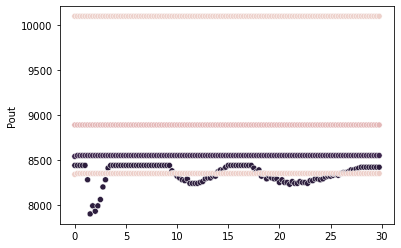

In [6]:
for time_step in range(0,3000,25):
  sns.scatterplot(data=top5, x=time_step/100, y=top5['Pout'+f':{time_step/100:,.3f}'], hue=top5['pin'], legend=False)

plt.ylabel('Pout')
plt.show()


In [7]:
# see the number of electrical power output simulations with all-time unchanged data
duplicates = 20

valid_pins = []
for index, row in inputs_results_main30yr_Pout.iterrows():
  if row.nunique() > len(row)-duplicates and row[-1] > 50:
    valid_pins.append(row[0])
  else:
    pass
len(valid_pins)


494

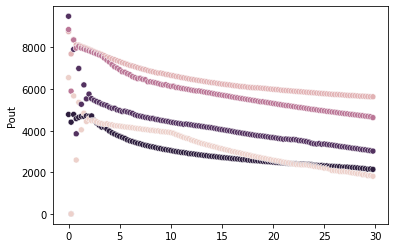

Top-5 high-performance simulation:  2744     658302738
2752     754860555
35186    903984808
41287    957964381
35195    611376788
Name: pin, dtype: int64


In [8]:
# plot top-5 valid high-performance simulations by electrical power output

inputs_results_main30yr_Pout_valid = inputs_results_main30yr_Pout[inputs_results_main30yr_Pout['pin'].isin(valid_pins)]
top5_Pout_valid = inputs_results_main30yr_Pout_valid.sort_values(by=inputs_results_main30yr_Pout_valid.columns[-1], ascending=False).head(5)

for time_step in range(0,3000,25):
  sns.scatterplot(data=top5_Pout_valid, x=time_step/100, y=top5_Pout_valid['Pout'+f':{time_step/100:,.3f}'], hue=top5_Pout_valid['pin'], legend=False)

plt.ylabel('Pout')
plt.show()

print('Top-5 high-performance simulation: ', top5_Pout_valid['pin'])


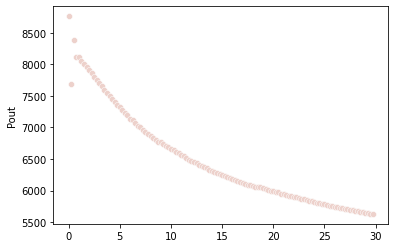

High-performance simulation:  2744    658302738
Name: pin, dtype: int64


In [9]:
# plot high-performance simulation by electrical power output

top_Pout_valid_high = inputs_results_main30yr_Pout_valid.sort_values(by=inputs_results_main30yr_Pout_valid.columns[-1], ascending=False).head(1)

for time_step in range(0,3000,25):
  sns.scatterplot(data=top_Pout_valid_high, x=time_step/100, y=top_Pout_valid_high['Pout'+f':{time_step/100:,.3f}'], hue=top_Pout_valid_high['pin'], legend=False)

plt.ylabel('Pout')
plt.show()

print('High-performance simulation: ', top_Pout_valid_high['pin'])


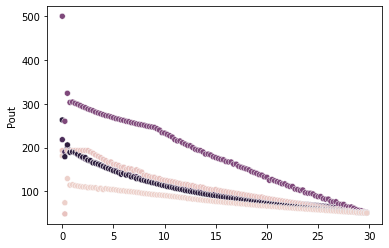

Bottom-5 low-performance simulation:  23210    813274794
21304    720983041
21738    416278033
36562    878291145
20863    385011569
Name: pin, dtype: int64


In [10]:
# plot bottom-5 valid low-performance simulations by electrical power output

inputs_results_main30yr_Pout_valid = inputs_results_main30yr_Pout[inputs_results_main30yr_Pout['pin'].isin(valid_pins)]
btm5_Pout_valid = inputs_results_main30yr_Pout_valid.sort_values(by=inputs_results_main30yr_Pout_valid.columns[-1], ascending=False).tail(5)

for time_step in range(0,3000,25):
  sns.scatterplot(data=btm5_Pout_valid, x=time_step/100, y=btm5_Pout_valid['Pout'+f':{time_step/100:,.3f}'], hue=btm5_Pout_valid['pin'], legend=False)

plt.ylabel('Pout')
plt.show()

print('Bottom-5 low-performance simulation: ', btm5_Pout_valid['pin'])


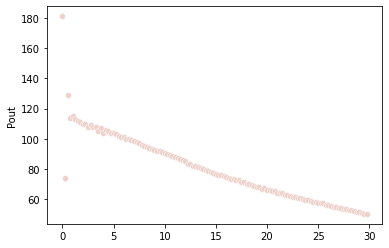

Low performance simulation:  20863    385011569
Name: pin, dtype: int64


In [11]:
# plot low-performance simulation by electrical power output

btm_Pout_valid_low = inputs_results_main30yr_Pout_valid.sort_values(by=inputs_results_main30yr_Pout_valid.columns[-1], ascending=False).tail(1)

for time_step in range(0,3000,25):
  sns.scatterplot(data=btm_Pout_valid_low, x=time_step/100, y=btm_Pout_valid_low['Pout'+f':{time_step/100:,.3f}'], hue=btm_Pout_valid_low['pin'], legend=False)

plt.ylabel('Pout')
plt.show()

print('Low performance simulation: ', btm_Pout_valid_low['pin'])


In [12]:
inputs_results_main30yr_Pout_valid

,pin,Pout:0.000,Pout:0.250,Pout:0.500,Pout:0.750,Pout:1.000,Pout:1.250,Pout:1.500,Pout:1.750,Pout:2.000,...,Pout:27.500,Pout:27.750,Pout:28.000,Pout:28.250,Pout:28.500,Pout:28.750,Pout:29.000,Pout:29.250,Pout:29.500,Pout:29.750
2,555177737,1950.0,825.0,1110.0,1040.0,1030.0,1030.0,1040.0,1020.0,1020.0,...,670.0,668.0,667.0,665.0,664.0,662.0,661.0,659.0,658.0,656.0
19,730106141,576.0,319.0,408.0,367.0,369.0,374.0,369.0,361.0,365.0,...,206.0,205.0,205.0,204.0,203.0,203.0,202.0,202.0,201.0,200.0
34,722207808,1700.0,976.0,1240.0,1120.0,1150.0,1160.0,1150.0,1130.0,1140.0,...,770.0,768.0,766.0,764.0,763.0,761.0,759.0,757.0,756.0,754.0
41,266741007,1940.0,484.0,686.0,651.0,649.0,650.0,646.0,638.0,632.0,...,418.0,417.0,417.0,416.0,415.0,414.0,414.0,413.0,412.0,411.0
47,983147230,2000.0,855.0,1140.0,1070.0,1060.0,1060.0,1080.0,1050.0,1050.0,...,696.0,695.0,693.0,692.0,690.0,689.0,687.0,686.0,684.0,683.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43972,124640817,751.0,0.0,750.0,310.0,701.0,516.0,624.0,596.0,583.0,...,216.0,212.0,208.0,204.0,200.0,196.0,192.0,188.0,184.0,180.0
44068,430698483,2290.0,1800.0,1830.0,1650.0,1580.0,1490.0,1400.0,1360.0,1300.0,...,277.0,274.0,272.0,269.0,267.0,264.0,262.0,260.0,257.0,255.0
44219,192786637,990.0,407.0,833.0,649.0,735.0,691.0,697.0,687.0,678.0,...,224.0,221.0,219.0,216.0,213.0,210.0,207.0,205.0,202.0,199.0
44320,285475897,1180.0,634.0,821.0,739.0,748.0,744.0,738.0,741.0,734.0,...,427.0,426.0,425.0,423.0,422.0,421.0,420.0,418.0,417.0,416.0


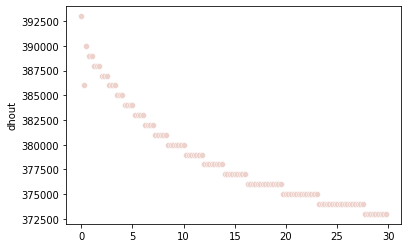

High performance simulation:  2744    658302738
Name: pin, dtype: int64


In [13]:
# plot high-performance simulation by thermal recovery
top_dhout = inputs_results_main30yr[inputs_results_main30yr['pin'].isin(top_Pout_valid_high['pin'])]
for time_step in range(0,3000,25):
  sns.scatterplot(data=top_dhout, x=time_step/100, y=top_dhout['dhout'+f':{time_step/100:,.3f}'], hue=top_dhout['pin'], legend=False)

plt.ylabel('dhout')
plt.show()

print('High performance simulation: ', top_dhout['pin'])


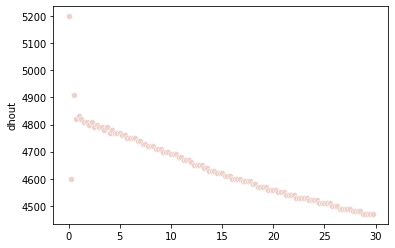

Low performance simulation:  20863    385011569
Name: pin, dtype: int64


In [14]:
# plot low-performance simulation by thermal recovery
btm_dhout = inputs_results_main30yr[inputs_results_main30yr['pin'].isin(btm_Pout_valid_low['pin'])]
for time_step in range(0,3000,25):
  sns.scatterplot(data=btm_dhout, x=time_step/100, y=btm_dhout['dhout'+f':{time_step/100:,.3f}'], hue=btm_dhout['pin'], legend=False)

plt.ylabel('dhout')
plt.show()

print('Low performance simulation: ', btm_dhout['pin'])


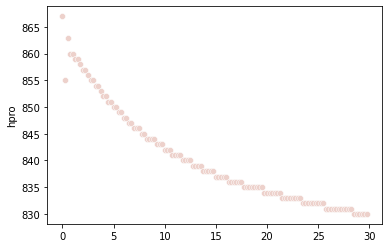

High performance simulation:  2744    658302738
Name: pin, dtype: int64


In [15]:
# plot high-performance simulation by production enthalpy
for time_step in range(0,3000,25):
  sns.scatterplot(data=top_dhout, x=time_step/100, y=top_dhout['hpro'+f':{time_step/100:,.3f}'], hue=top_dhout['pin'], legend=False)

plt.ylabel('hpro')
plt.show()

print('High performance simulation: ', top_dhout['pin'])


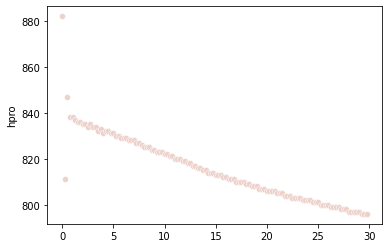

Low performance simulation:  20863    385011569
Name: pin, dtype: int64


In [16]:
# plot low-performance simulation by production enthalpy
for time_step in range(0,3000,25):
  sns.scatterplot(data=btm_dhout, x=time_step/100, y=btm_dhout['hpro'+f':{time_step/100:,.3f}'], hue=btm_dhout['pin'], legend=False)

plt.ylabel('hpro')
plt.show()

print('Low performance simulation: ', btm_dhout['pin'])


In [17]:
print('High performance simulation well spacing: ', list(inputs_results_main30yr[inputs_results_main30yr['pin'] == 658302738]['w_spacing']))
print('Low performance simulation well spacing: ', list(inputs_results_main30yr[inputs_results_main30yr['pin'] == 385011569]['w_spacing']))


High performance simulation well spacing:  [159.0]
Low performance simulation well spacing:  [247.0]


## Plot performance by calculated amount of enthalpy


### Timeseries without Losses

In [18]:
# P_usable = 0.13 * (dhout + (h_95C - h_120C) * mpro)

h_95C = 398.11 #kJ/kg
h_120C = 503.81 #kJ/kg


In [19]:
inputs_results_main30yr_P_usable = inputs_results_main30yr.copy()

for time_step in range(0,3000,25):
  inputs_results_main30yr_P_usable['P_usable'+f':{time_step/100:,.3f}'] = 0.13 * (inputs_results_main30yr_P_usable['dhout'+f':{time_step/100:,.3f}'] + (h_95C - h_120C) * inputs_results_main30yr_P_usable['mpro'])

inputs_results_main30yr_P_usable.head(3)


,pin,size,ResDepth,ResGradient,ResRho,ResKt,ResSv,AmbTempC,AmbPres,ResE,...,P_usable:27.500,P_usable:27.750,P_usable:28.000,P_usable:28.250,P_usable:28.500,P_usable:28.750,P_usable:29.000,P_usable:29.250,P_usable:29.500,P_usable:29.750
0,997602694,1600.0,2360.0,84.4,2590.0,2.39,3030.0,0,0.101,5.990000e+10,...,-2972.374600,-2972.374600,-2972.374600,-2972.374600,-2972.374600,-2972.374600,-2985.374600,-2985.374600,-2985.374600,-2985.374600
1,874689955,1600.0,2360.0,85.0,2870.0,2.77,2160.0,0,0.101,5.590000e+10,...,-209.293322,-209.293322,-209.293322,-209.293322,-209.293322,-209.293322,-209.293322,-209.293322,-209.293322,-209.293322
2,555177737,1600.0,2350.0,86.6,2730.0,3.54,2040.0,0,0.101,6.020000e+10,...,8023.028000,8023.028000,8023.028000,8023.028000,8023.028000,8023.028000,8023.028000,8023.028000,8023.028000,8010.028000


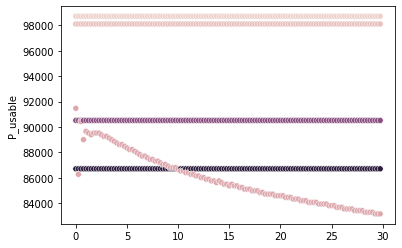

In [20]:
# plot top-5 simulations by calculated amount of enthalpy
cols_p_usable = [c for c in inputs_results_main30yr_P_usable.columns if c[:4] == 'pin' or c[:8] == 'P_usable']
inputs_results_main30yr_P_usable_x = inputs_results_main30yr_P_usable[cols_p_usable]
top5 = inputs_results_main30yr_P_usable_x.sort_values(by=inputs_results_main30yr_P_usable_x.columns[-1], ascending=False).head(5)

for time_step in range(0,3000,25):
  sns.scatterplot(data=top5, x=time_step/100, y=top5['P_usable'+f':{time_step/100:,.3f}'], hue=top5['pin'], legend=False)

plt.ylabel('P_usable')
plt.show()


In [21]:
# see the number of calculated amount of enthalpy simulations with all-time unchanged data
duplicates = 20

valid_pins = []
for index, row in inputs_results_main30yr_P_usable_x.iterrows():
  if row.nunique() > len(row)-duplicates and row[-1] > 50 and row[1] > 100:
    valid_pins.append(row[0])
  else:
    pass
len(valid_pins)


14843

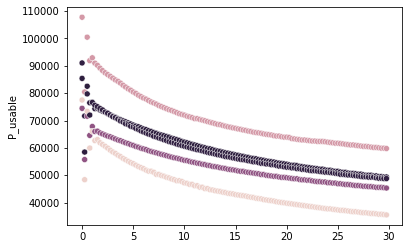

Top-5 high-performance simulation:  39456    299774151
36197    833619589
28429    818212256
3627     558526726
20544    120356629
Name: pin, dtype: int64


In [22]:
# plot top-5 valid high-performance simulations by calculated amount of enthalpy

inputs_results_main30yr_P_usable_x_valid = inputs_results_main30yr_P_usable_x[inputs_results_main30yr_P_usable_x['pin'].isin(valid_pins)]
top5_P_usable_x_valid = inputs_results_main30yr_P_usable_x_valid.sort_values(by=inputs_results_main30yr_P_usable_x_valid.columns[-1], ascending=False).head(5)

for time_step in range(0,3000,25):
  sns.scatterplot(data=top5_P_usable_x_valid, x=time_step/100, y=top5_P_usable_x_valid['P_usable'+f':{time_step/100:,.3f}'], hue=top5_P_usable_x_valid['pin'], legend=False)

plt.ylabel('P_usable')
plt.show()

print('Top-5 high-performance simulation: ', top5_P_usable_x_valid['pin'])


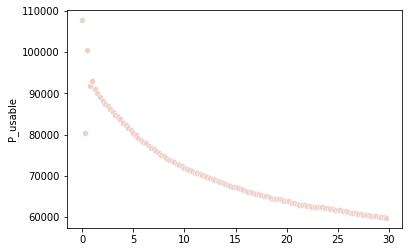

High-performance simulation:  39456    299774151
Name: pin, dtype: int64


In [23]:
# plot high-performance simulation by calculated amount of enthalpy

top_P_usable_x_valid_high = inputs_results_main30yr_P_usable_x_valid.sort_values(by=inputs_results_main30yr_P_usable_x_valid.columns[-1], ascending=False).head(1)

for time_step in range(0,3000,25):
  sns.scatterplot(data=top_P_usable_x_valid_high, x=time_step/100, y=top_P_usable_x_valid_high['P_usable'+f':{time_step/100:,.3f}'], hue=top_P_usable_x_valid_high['pin'], legend=False)

plt.ylabel('P_usable')
plt.show()

print('High-performance simulation: ', top_P_usable_x_valid_high['pin'])


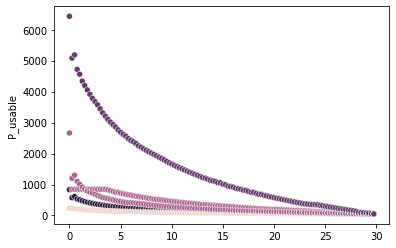

Bottom-5 low-performance simulation:  9573     635473929
40486    844097656
10168    444307692
36798    651610869
28531    755579214
Name: pin, dtype: int64


In [24]:
# plot bottom-5 valid low-performance simulations by calculated amount of enthalpy

inputs_results_main30yr_P_usable_x_valid = inputs_results_main30yr_P_usable_x[inputs_results_main30yr_P_usable_x['pin'].isin(valid_pins)]
btm5_P_usable_x_valid = inputs_results_main30yr_P_usable_x_valid.sort_values(by=inputs_results_main30yr_P_usable_x_valid.columns[-1], ascending=False).tail(5)

for time_step in range(0,3000,25):
  sns.scatterplot(data=btm5_P_usable_x_valid, x=time_step/100, y=btm5_P_usable_x_valid['P_usable'+f':{time_step/100:,.3f}'], hue=btm5_P_usable_x_valid['pin'], legend=False)

plt.ylabel('P_usable')
plt.show()

print('Bottom-5 low-performance simulation: ', btm5_P_usable_x_valid['pin'])


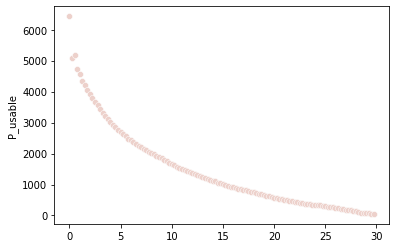

Low performance simulation:  28531    755579214
Name: pin, dtype: int64


In [25]:
# plot low-performance simulation by calculated amount of enthalpy

btm_P_usable_x_valid_low = inputs_results_main30yr_P_usable_x_valid.sort_values(by=inputs_results_main30yr_P_usable_x_valid.columns[-1], ascending=False).tail(1)

for time_step in range(0,3000,25):
  sns.scatterplot(data=btm_P_usable_x_valid_low, x=time_step/100, y=btm_P_usable_x_valid_low['P_usable'+f':{time_step/100:,.3f}'], hue=btm_P_usable_x_valid_low['pin'], legend=False)

plt.ylabel('P_usable')
plt.show()

print('Low performance simulation: ', btm_P_usable_x_valid_low['pin'])


In [26]:
print('High performance simulation well spacing: ', list(inputs_results_main30yr[inputs_results_main30yr['pin'] == 299774151]['w_spacing']))
print('Low performance simulation well spacing: ', list(inputs_results_main30yr[inputs_results_main30yr['pin'] == 877195377]['w_spacing']))


High performance simulation well spacing:  [706.0]
Low performance simulation well spacing:  [687.0]


### Cumulative without Losses

In [28]:
# P_usable = 1 / 30 * \int^{30}_{0} 0.13 * (dhout + (h_95C - h_120C) * mpro) dt
P_usable_cum_dict = pd.DataFrame(columns=['pin', 'P_usable_cum'])

for index, row in inputs_results_main30yr_P_usable.iterrows():
  P_usable_cum = 0
  obj_func = lambda x: 0.13 * (x + (h_95C - h_120C) * row['mpro'])

  for time_step in range(0,3000,25):
    if time_step/100-0.250 > 0:
     dhout_0 = row['dhout'+f':{time_step/100-0.250:,.3f}']
     dhout_1 = row['dhout'+f':{time_step/100:,.3f}']
    else:
      pass

  P_usable_cum += integrate.quad(obj_func, dhout_0, dhout_1)[0]
  P_usable_cum_dict = P_usable_cum_dict.append({'pin': row['pin'], 'P_usable_cum': P_usable_cum / 30}, ignore_index=True)

P_usable_cum_dict.head(3)


,pin,P_usable_cum
0,997602694.0,0.00
1,874689955.0,0.00
2,555177737.0,-26721.76


In [29]:
inputs_results_main30yr_P_usable = pd.merge(inputs_results_main30yr_P_usable, P_usable_cum_dict, on='pin')
inputs_results_main30yr_P_usable.head(3)


,pin,size,ResDepth,ResGradient,ResRho,ResKt,ResSv,AmbTempC,AmbPres,ResE,...,P_usable:27.750,P_usable:28.000,P_usable:28.250,P_usable:28.500,P_usable:28.750,P_usable:29.000,P_usable:29.250,P_usable:29.500,P_usable:29.750,P_usable_cum
0,997602694,1600.0,2360.0,84.4,2590.0,2.39,3030.0,0,0.101,5.990000e+10,...,-2972.374600,-2972.374600,-2972.374600,-2972.374600,-2972.374600,-2985.374600,-2985.374600,-2985.374600,-2985.374600,0.00
1,874689955,1600.0,2360.0,85.0,2870.0,2.77,2160.0,0,0.101,5.590000e+10,...,-209.293322,-209.293322,-209.293322,-209.293322,-209.293322,-209.293322,-209.293322,-209.293322,-209.293322,0.00
2,555177737,1600.0,2350.0,86.6,2730.0,3.54,2040.0,0,0.101,6.020000e+10,...,8023.028000,8023.028000,8023.028000,8023.028000,8023.028000,8023.028000,8023.028000,8023.028000,8010.028000,-26721.76


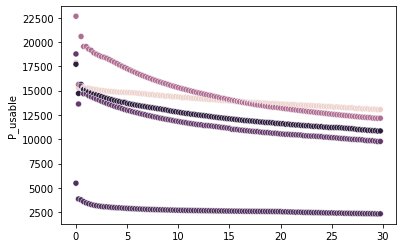

Top-5 high-performance simulation:  12733    518409604
12554    621380814
24110    738765594
11549    689742404
32649    707071244
Name: pin, dtype: int64


In [30]:
# plot top-5 valid high-performance simulations by calculated amount of enthalpy (cumulated)

inputs_results_main30yr_P_usable_cum_valid = inputs_results_main30yr_P_usable[inputs_results_main30yr_P_usable['pin'].isin(valid_pins)]
top5_P_usable_cum_valid = inputs_results_main30yr_P_usable_cum_valid.sort_values(by='P_usable_cum', ascending=False).head(5)

for time_step in range(0,3000,25):
  sns.scatterplot(data=top5_P_usable_cum_valid, x=time_step/100, y=top5_P_usable_cum_valid['P_usable'+f':{time_step/100:,.3f}'], hue=top5_P_usable_cum_valid['pin'], legend=False)

plt.ylabel('P_usable')
plt.show()

print('Top-5 high-performance simulation: ', top5_P_usable_cum_valid['pin'])


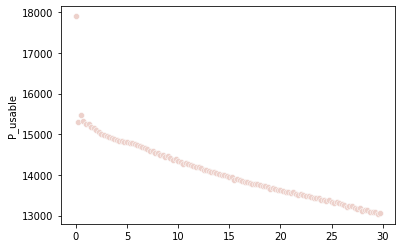

High-performance simulation:  12733    518409604
Name: pin, dtype: int64


In [31]:
# plot high-performance simulation by calculated amount of enthalpy

top_P_usable_cum_valid_high = top5_P_usable_cum_valid.head(1)

for time_step in range(0,3000,25):
  sns.scatterplot(data=top_P_usable_cum_valid_high, x=time_step/100, y=top_P_usable_cum_valid_high['P_usable'+f':{time_step/100:,.3f}'], hue=top_P_usable_cum_valid_high['pin'], legend=False)

plt.ylabel('P_usable')
plt.show()

print('High-performance simulation: ', top_P_usable_cum_valid_high['pin'])


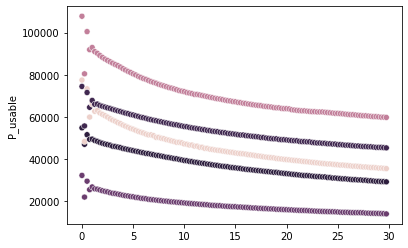

Bottom-5 low-performance simulation:  24286    480003737
35882    596586756
20549    120356629
3630     558526726
39461    299774151
Name: pin, dtype: int64


In [32]:
# plot bottom-5 valid low-performance simulations by calculated amount of enthalpy (cumulated)
btm5_P_usable_cum_valid = inputs_results_main30yr_P_usable_cum_valid.sort_values(by='P_usable_cum', ascending=False).tail(5)

for time_step in range(0,3000,25):
  sns.scatterplot(data=btm5_P_usable_cum_valid, x=time_step/100, y=btm5_P_usable_cum_valid['P_usable'+f':{time_step/100:,.3f}'], hue=btm5_P_usable_cum_valid['pin'], legend=False)

plt.ylabel('P_usable')
plt.show()

print('Bottom-5 low-performance simulation: ', btm5_P_usable_cum_valid['pin'])


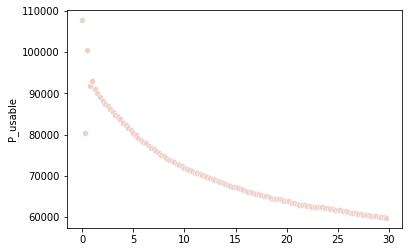

Low performance simulation:  39461    299774151
Name: pin, dtype: int64


In [33]:
# plot low-performance simulation by calculated amount of enthalpy

btm_P_usable_cum_valid_low = btm5_P_usable_cum_valid.tail(1)

for time_step in range(0,3000,25):
  sns.scatterplot(data=btm_P_usable_cum_valid_low, x=time_step/100, y=btm_P_usable_cum_valid_low['P_usable'+f':{time_step/100:,.3f}'], hue=btm_P_usable_cum_valid_low['pin'], legend=False)

plt.ylabel('P_usable')
plt.show()

print('Low performance simulation: ', btm_P_usable_cum_valid_low['pin'])


In [34]:
print('High performance simulation well spacing: ', list(inputs_results_main30yr[inputs_results_main30yr['pin'] == 299774151]['w_spacing']))
print('Low performance simulation well spacing: ', list(inputs_results_main30yr[inputs_results_main30yr['pin'] == 374070519]['w_spacing']))


High performance simulation well spacing:  [706.0]
Low performance simulation well spacing:  [135.0]


### Timeseries with Losses

In [35]:
# P_usable = 0.13 * (dhout + (h_95C - h_120C - v5 * (Pinj - Pwhp)) * mpro)
inputs_results_main30yr_P_usable_loss = inputs_results_main30yr_P_usable.copy()

for time_step in range(0,3000,25):
  inputs_results_main30yr_P_usable_loss['P_usable_loss'+f':{time_step/100:,.3f}'] =\
  0.13 * (inputs_results_main30yr_P_usable_loss['dhout'+f':{time_step/100:,.3f}'] +\
          (h_95C - h_120C - inputs_results_main30yr_P_usable_loss['v5'] *\
           abs(inputs_results_main30yr_P_usable_loss['pinj'] -\
            inputs_results_main30yr_P_usable_loss['p_whp'])) *\
          inputs_results_main30yr_P_usable_loss['mpro'])

inputs_results_main30yr_P_usable_loss.head(3)

,pin,size,ResDepth,ResGradient,ResRho,ResKt,ResSv,AmbTempC,AmbPres,ResE,...,P_usable_loss:27.500,P_usable_loss:27.750,P_usable_loss:28.000,P_usable_loss:28.250,P_usable_loss:28.500,P_usable_loss:28.750,P_usable_loss:29.000,P_usable_loss:29.250,P_usable_loss:29.500,P_usable_loss:29.750
0,997602694,1600.0,2360.0,84.4,2590.0,2.39,3030.0,0,0.101,5.990000e+10,...,5968.149341,5968.149341,5968.149341,5968.149341,5968.149341,5968.149341,5955.149341,5955.149341,5955.149341,5955.149341
1,874689955,1600.0,2360.0,85.0,2870.0,2.77,2160.0,0,0.101,5.590000e+10,...,-209.229513,-209.229513,-209.229513,-209.229513,-209.229513,-209.229513,-209.229513,-209.229513,-209.229513,-209.229513
2,555177737,1600.0,2350.0,86.6,2730.0,3.54,2040.0,0,0.101,6.020000e+10,...,22202.914670,22202.914670,22202.914670,22202.914670,22202.914670,22202.914670,22202.914670,22202.914670,22202.914670,22189.914670


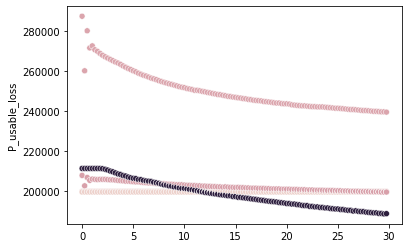

In [36]:
# plot top-5 simulations by calculated amount of enthalpy (with losses)
cols_p_usable = [c for c in inputs_results_main30yr_P_usable_loss.columns if c[:4] == 'pin' or c[:13] == 'P_usable_loss']
inputs_results_main30yr_P_usable_loss_x = inputs_results_main30yr_P_usable_loss[cols_p_usable]
top5 = inputs_results_main30yr_P_usable_loss_x.sort_values(by=inputs_results_main30yr_P_usable_loss_x.columns[-1], ascending=False).head(5)

for time_step in range(0,3000,25):
  sns.scatterplot(data=top5, x=time_step/100, y=top5['P_usable_loss'+f':{time_step/100:,.3f}'], hue=top5['pin'], legend=False)

plt.ylabel('P_usable_loss')
plt.show()


In [37]:
# see the number of calculated amount of enthalpy (with losses) simulations with all-time unchanged data
duplicates = 20

valid_pins = []
for index, row in inputs_results_main30yr_P_usable_loss_x.iterrows():
  if row.nunique() > len(row)-duplicates and row[-1] > 0: # and row[1] > 100:
    valid_pins.append(row[0])
  else:
    pass
len(valid_pins)


15475

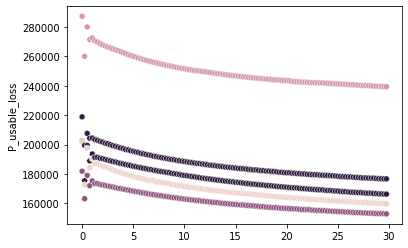

Top-5 high-performance simulation:  39461    299774151
28434    818212256
36202    833619589
20549    120356629
3630     558526726
Name: pin, dtype: int64


In [38]:
# plot top-5 valid high-performance simulations by calculated amount of enthalpy (with losses)
inputs_results_main30yr_P_usable_loss_valid = inputs_results_main30yr_P_usable_loss[inputs_results_main30yr_P_usable_loss['pin'].isin(valid_pins)]
top5_P_usable_loss_valid = inputs_results_main30yr_P_usable_loss_valid.sort_values(by=inputs_results_main30yr_P_usable_loss_valid.columns[-1], ascending=False).head(5)

for time_step in range(0,3000,25):
  sns.scatterplot(data=top5_P_usable_loss_valid, x=time_step/100, y=top5_P_usable_loss_valid['P_usable_loss'+f':{time_step/100:,.3f}'], hue=top5_P_usable_loss_valid['pin'], legend=False)

plt.ylabel('P_usable_loss')
plt.show()

print('Top-5 high-performance simulation: ', top5_P_usable_loss_valid['pin'])


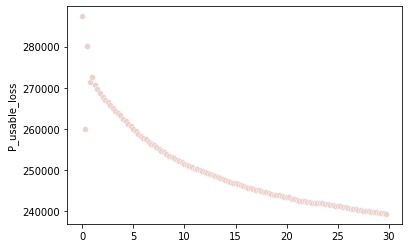

High-performance simulation:  39461    299774151
Name: pin, dtype: int64


In [39]:
# plot high-performance simulation by calculated amount of enthalpy (with losses)

top_P_usable_loss_valid_high = inputs_results_main30yr_P_usable_loss_valid.sort_values(by=inputs_results_main30yr_P_usable_loss_valid.columns[-1], ascending=False).head(1)

for time_step in range(0,3000,25):
  sns.scatterplot(data=top_P_usable_loss_valid_high, x=time_step/100, y=top_P_usable_loss_valid_high['P_usable_loss'+f':{time_step/100:,.3f}'], hue=top_P_usable_loss_valid_high['pin'], legend=False)

plt.ylabel('P_usable_loss')
plt.show()

print('High-performance simulation: ', top_P_usable_loss_valid_high['pin'])


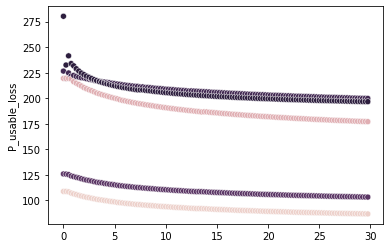

Bottom-5 low-performance simulation:  42291    960726872
3849     999067646
6333     633108900
13677    920166809
13679    569132087
Name: pin, dtype: int64


In [40]:
# plot bottom-5 valid low-performance simulations by calculated amount of enthalpy (with losses)

inputs_results_main30yr_P_usable_loss_valid = inputs_results_main30yr_P_usable_loss[inputs_results_main30yr_P_usable_loss['pin'].isin(valid_pins)]
btm5_P_usable_loss_valid = inputs_results_main30yr_P_usable_loss_valid.sort_values(by=inputs_results_main30yr_P_usable_loss_valid.columns[-1], ascending=False).tail(5)

for time_step in range(0,3000,25):
  sns.scatterplot(data=btm5_P_usable_loss_valid, x=time_step/100, y=btm5_P_usable_loss_valid['P_usable_loss'+f':{time_step/100:,.3f}'], hue=btm5_P_usable_loss_valid['pin'], legend=False)

plt.ylabel('P_usable_loss')
plt.show()

print('Bottom-5 low-performance simulation: ', btm5_P_usable_loss_valid['pin'])


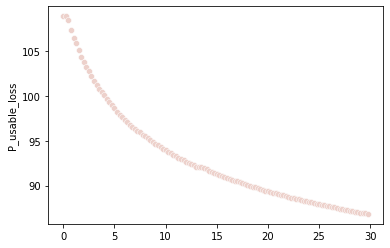

Low performance simulation:  13679    569132087
Name: pin, dtype: int64


In [41]:
# plot low-performance simulation by calculated amount of enthalpy (with losses)

btm_P_usable_loss_valid_low = inputs_results_main30yr_P_usable_loss_valid.sort_values(by=inputs_results_main30yr_P_usable_loss_valid.columns[-1], ascending=False).tail(1)

for time_step in range(0,3000,25):
  sns.scatterplot(data=btm_P_usable_loss_valid_low, x=time_step/100, y=btm_P_usable_loss_valid_low['P_usable_loss'+f':{time_step/100:,.3f}'], hue=btm_P_usable_loss_valid_low['pin'], legend=False)

plt.ylabel('P_usable_loss')
plt.show()

print('Low performance simulation: ', btm_P_usable_loss_valid_low['pin'])


In [42]:
print('High performance simulation well spacing: ', list(inputs_results_main30yr[inputs_results_main30yr['pin'] == 299774151]['w_spacing']))
print('Low performance simulation well spacing: ', list(inputs_results_main30yr[inputs_results_main30yr['pin'] == 569132087]['w_spacing']))


High performance simulation well spacing:  [706.0]
Low performance simulation well spacing:  [61.8]


# Boosting algorithm application

In [ ]:
# Look for categories by objection function
f, ax = plt.subplots(figsize=(5,5))

sns.histplot(inputs_results_main30yr_P_usable_loss['P_usable_cum'], ax=ax)

plt.axvline(280, c='r')
plt.axvline(3700, c='r')
plt.axvline(15000, c='r')
plt.xlim(1, 30000)

plt.show()


KeyboardInterrupt: ignored

In [135]:
# Create categories
P_usable_cat1 = inputs_results_main30yr_P_usable_loss[inputs_results_main30yr_P_usable_loss['P_usable_cum'].between(1, 280)]
P_usable_cat2 = inputs_results_main30yr_P_usable_loss[inputs_results_main30yr_P_usable_loss['P_usable_cum'].between(280, 3700)]
P_usable_cat3 = inputs_results_main30yr_P_usable_loss[inputs_results_main30yr_P_usable_loss['P_usable_cum'].between(3700, 15000)]
P_usable_cat4 = inputs_results_main30yr_P_usable_loss[inputs_results_main30yr_P_usable_loss['P_usable_cum'] > 15000]

P_usable_cat1['P_usable_cum_cat'] = 1
P_usable_cat2['P_usable_cum_cat'] = 2
P_usable_cat3['P_usable_cum_cat'] = 3
P_usable_cat4['P_usable_cum_cat'] = 4

P_usable_cat1_2 = P_usable_cat1.append(P_usable_cat2)
P_usable_cat3_4 = P_usable_cat3.append(P_usable_cat4)

inputs_results_main30yr_P_usable_loss_cat = P_usable_cat1_2.append(P_usable_cat3_4).sort_index()
inputs_results_main30yr_P_usable_loss_cat['P_usable_cum_cat'].value_counts()


In [138]:
# Prepare the data. Remove objective function components and timeseries
X = inputs_results_main30yr_P_usable_loss_cat.copy()

for time_step in range(0,3000,25):
  X.drop(columns={'Pout'+f':{time_step/100:,.3f}', 'dhout'+f':{time_step/100:,.3f}',\
                  'hpro'+f':{time_step/100:,.3f}', 'P_usable'+f':{time_step/100:,.3f}',\
                  'P_usable_loss'+f':{time_step/100:,.3f}'}, inplace=True)
  
X.drop(columns={'v5', 'pinj', 'p_whp', 'mpro', 'P_usable_cum', 'P_usable_cum_cat'}, inplace=True)
y = inputs_results_main30yr_P_usable_loss_cat['P_usable_cum_cat']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2,
                                                      random_state=rnd_state)
print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)


(1284, 132)
(322, 132)
(1284,)
(322,)


In [139]:
model_cbc = CatBoostClassifier(
    iterations=100,
    random_seed=rnd_state,
    learning_rate=0.2)


In [140]:
%%time
start = time.time()
model_cbc.fit(
    X_train, y_train,
    eval_set=(X_valid, y_valid),
    verbose=False,
    plot=True)
end = time.time()
catboost_time = end - start


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CPU times: user 4.67 s, sys: 137 ms, total: 4.81 s
Wall time: 10.4 s


In [141]:
start = time.time()
y_pred = model_cbc.predict(X_valid)
end = time.time()
catboost_time_predicting = end - start

print('Score: ', f1_score(y_valid, y_pred, average='macro'))
print('Learning time: ', catboost_time)
print('Prediction time: ', catboost_time_predicting)


Score:  0.674919003501806
Learning time:  10.374655723571777
Prediction time:  0.0033376216888427734


['qinj' 'qpro' 'recovery' 'qleak' 'hinj' 'Tinj' 'Qinj' 'Vinj' 'dia_last'
 's3Dip' 'nfstim' 'hfstim' 'bh_bound' 'BH_T']


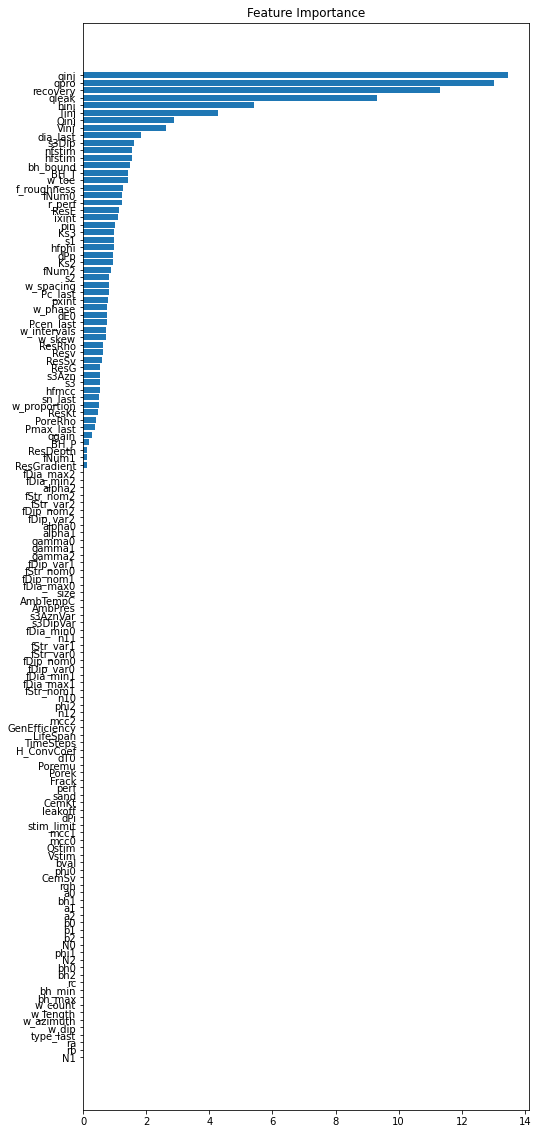

In [142]:
feature_importance = model_cbc.feature_importances_
sorted_idx = np.argsort(feature_importance)

fig = plt.figure(figsize=(8, 20))

plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_valid.columns)[sorted_idx])
plt.title('Feature Importance')

print(np.array(X_valid.columns)[sorted_idx][:-15:-1])


In [143]:
feature_importance[sorted_idx][feature_importance[sorted_idx] > 1]


array([ 1.00849058,  1.11163448,  1.15218707,  1.22211329,  1.22284564,
        1.25846857,  1.40793403,  1.42724792,  1.47141848,  1.53493456,
        1.5552299 ,  1.61895735,  1.83881555,  2.62231527,  2.87480503,
        4.28523947,  5.40243632,  9.31723193, 11.31858907, 13.0252882 ,
       13.4704483 ])

In [144]:
base_params = np.array(X_valid.columns)[sorted_idx][:-15:-1].tolist()
base_params.append(inputs_results_main30yr_P_usable_loss_cat.columns[-1])
inputs_results_main30yr_P_usable_loss_cat[base_params].groupby('P_usable_cum_cat').mean()


,qinj,qpro,recovery,qleak,hinj,Tinj,Qinj,Vinj,dia_last,s3Dip,nfstim,hfstim,bh_bound,BH_T
P_usable_cum_cat,,,,,,,,,,,,,,
1,0.050173,-0.024006,-0.731303,-0.026236,291.182716,61.664691,0.033601,3.180646e+07,2132.809877,0.064781,1.661728,2.469136,0.000606,473.809877
2,0.157056,-0.074416,-0.721810,-0.082946,277.100251,57.908521,0.071079,6.729596e+07,3255.824561,0.031969,2.654135,3.719298,0.000612,473.383459
3,0.339443,-0.123753,-0.437365,-0.216102,271.253102,56.365757,0.135752,1.285299e+08,4138.898263,0.007829,3.292804,4.158809,0.000684,473.684864
4,0.464850,-0.138204,-0.358152,-0.328003,282.568922,59.008020,0.156203,1.478893e+08,4091.454386,-0.000827,3.799499,4.393484,0.000709,473.616541


In [145]:
base_params_plots('qpro', title='Cumulative production rate, m3/s', xlim_hist=(-0.3, 0), ylim_hist=None, ylim=(-0.5, 0.1))
base_params_plots('recovery', title='Production rate/Injection rate ratio', xlim_hist=(-7, 2), ylim_hist=(0, 500), ylim=(-7, 2))
base_params_plots('w_spacing', title='Well spacing, m', xlim_hist=None, ylim_hist=None, ylim=None)
base_params_plots('qleak', title=' Boundary outflow rate, m3/s', xlim_hist=(-0.2, 0.1), ylim_hist=(0, 500), ylim=(-0.2, 0.1))
base_params_plots('r_perf', title='Perforation radus, m', xlim_hist=None, ylim_hist=None, ylim=None)
base_params_plots('nfstim', title='Number of stimulated natural fractures', xlim_hist=(0, 9), ylim_hist=None, ylim=(0, 9))
base_params_plots('dia_last', title='Final diameter of freshest fracture, m', xlim_hist=(0, 9000), ylim_hist=None, ylim=(0, 9000))
base_params_plots('hinj', title='Enthalpy of injected fluid, kJ/kg', xlim_hist=None, ylim_hist=None, ylim=None)
base_params_plots('Qinj', title='Circulation flow rate, m3/s', xlim_hist=None, ylim_hist=None, ylim=None)
base_params_plots('ixint', title='Number of fractures intercepting injectors', xlim_hist=None, ylim_hist=None, ylim=None)
base_params_plots('Tinj', title='Injection temperature, degC', xlim_hist=None, ylim_hist=None, ylim=None)
base_params_plots('Vinj', title='Injection volume, m3', xlim_hist=None, ylim_hist=None, ylim=None)
base_params_plots('hfstim', title='Number of stimulated hydraulic fractures', xlim_hist=None, ylim_hist=None, ylim=None)


NameError: ignored

# Optimal parameters actualization (20 year span)

In [ ]:
inputs_results_medium20yr = pd.read_csv('datasets/inputs_results_FORGE_medium20yr.csv')

inputs_results_medium20yr_P_usable = inputs_results_medium20yr.copy()

for time_step in range(0, 20000000, round(20000000/61)):
  inputs_results_medium20yr_P_usable['P_usable'+f':{time_step/1000000:,.3f}'] = 0.13 * (inputs_results_medium20yr_P_usable['dhout'+f':{time_step/1000000:,.3f}'] + (h_95C - h_120C) * inputs_results_medium20yr_P_usable['mpro'])

inputs_results_medium20yr_P_usable.head(3)


In [ ]:
P_usable_cum_dict = pd.DataFrame(columns=['pin', 'P_usable_cum'])

for index, row in inputs_results_medium20yr_P_usable.iterrows():
  P_usable_cum = 0
  for time_step in range(0, 20000000, round(20000000/61)):
    P_usable_cum += row['P_usable'+f':{time_step/1000000:,.3f}']
  P_usable_cum_dict = P_usable_cum_dict.append({'pin': row['pin'], 'P_usable_cum': P_usable_cum / 20}, ignore_index=True)

inputs_results_medium20yr_P_usable = pd.merge(inputs_results_medium20yr_P_usable, P_usable_cum_dict, on='pin')


In [ ]:
P_usable_cat1 = inputs_results_medium20yr_P_usable[inputs_results_medium20yr_P_usable['P_usable_cum'] < 3000]
P_usable_cat2 = inputs_results_medium20yr_P_usable[inputs_results_medium20yr_P_usable['P_usable_cum'].between(3000, 10000)]
P_usable_cat3 = inputs_results_medium20yr_P_usable[inputs_results_medium20yr_P_usable['P_usable_cum'].between(10000, 50000)]
P_usable_cat4 = inputs_results_medium20yr_P_usable[inputs_results_medium20yr_P_usable['P_usable_cum'] > 50000]

f, ax = plt.subplots(1, 2, figsize=(15,5))
sns.boxplot(data=pd.DataFrame({'<3000 kJ/s': P_usable_cat1['w_spacing'], '3000-10000 kJ/s': P_usable_cat2['w_spacing'],\
                               '10000-50000 kJ/s': P_usable_cat3['w_spacing'], '>50000 kJ/s': P_usable_cat4['w_spacing']}), ax=ax[0])
sns.histplot(data=pd.DataFrame({'<3000 kJ/s': P_usable_cat1['w_spacing'], '3000-10000 kJ/s': P_usable_cat2['w_spacing'],\
                               '10000-50000 kJ/s': P_usable_cat3['w_spacing'], '>50000 kJ/s': P_usable_cat4['w_spacing']}), multiple='stack', ax=ax[1])
ax[0].set(xlabel='P_usable_cum', ylabel='w_spacing')
ax[1].set(xlabel='w_spacing')

plt.show()


In [ ]:
f, ax = plt.subplots(figsize=(5,5))

sns.histplot(inputs_results_medium20yr_P_usable['P_usable_cum'], ax=ax)

plt.axvline(3000, c='r')
plt.axvline(10000, c='r')
plt.axvline(50000, c='r')
plt.xlim(0, 100000)
plt.show()


In [ ]:
P_usable_cat1['P_usable_cum_cat'] = 1
P_usable_cat2['P_usable_cum_cat'] = 2
P_usable_cat3['P_usable_cum_cat'] = 3
P_usable_cat4['P_usable_cum_cat'] = 4

P_usable_cat1_2 = P_usable_cat1.append(P_usable_cat2)
P_usable_cat3_4 = P_usable_cat3.append(P_usable_cat4)

inputs_results_medium20yr_P_usable_cat = P_usable_cat1_2.append(P_usable_cat3_4).sort_index()


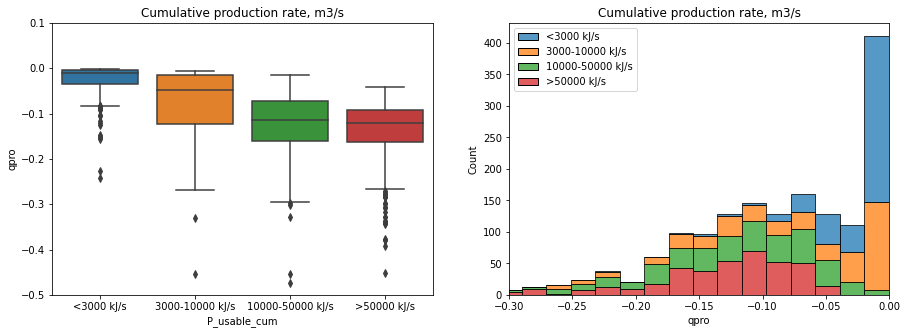

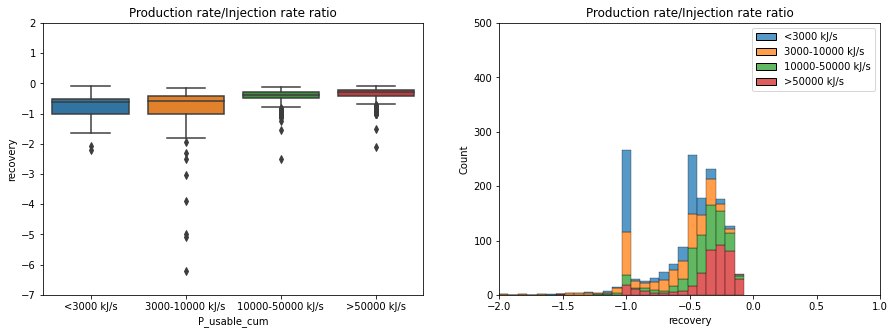

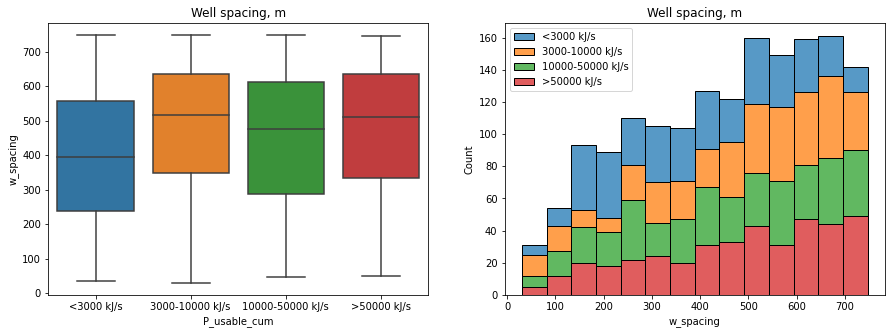

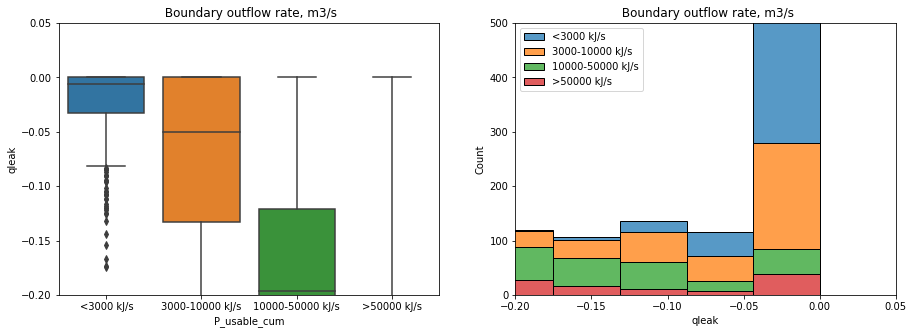

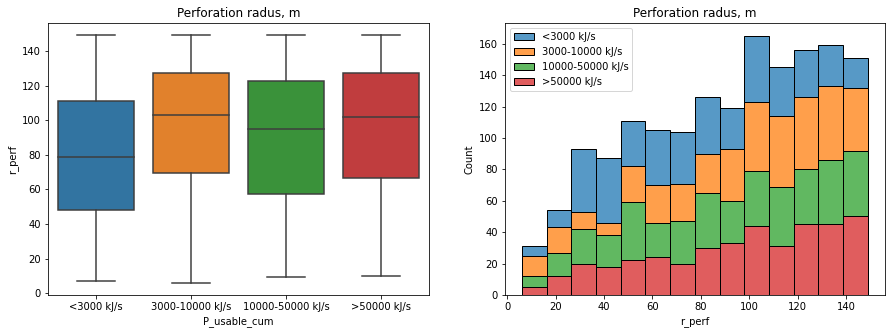

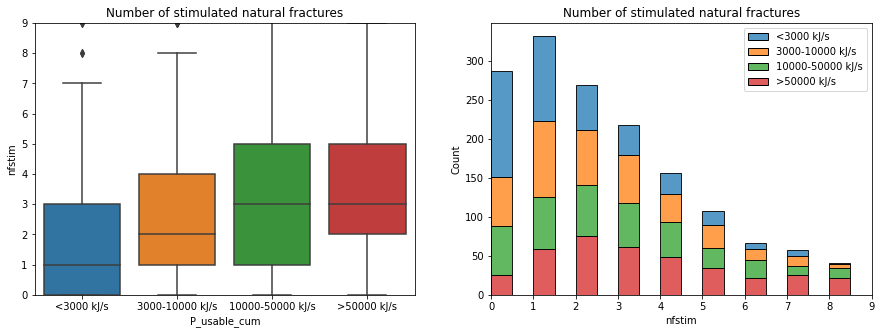

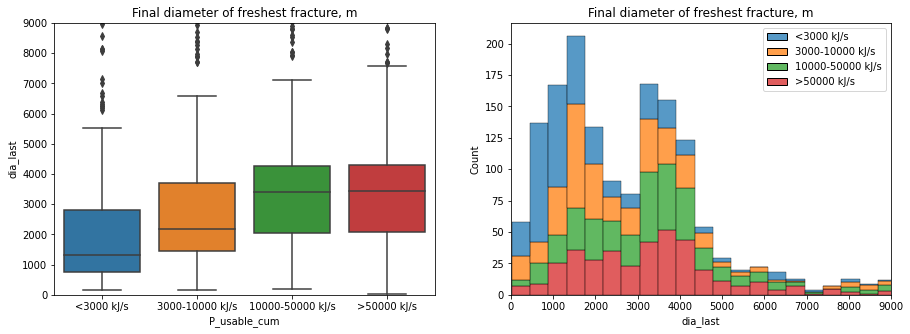

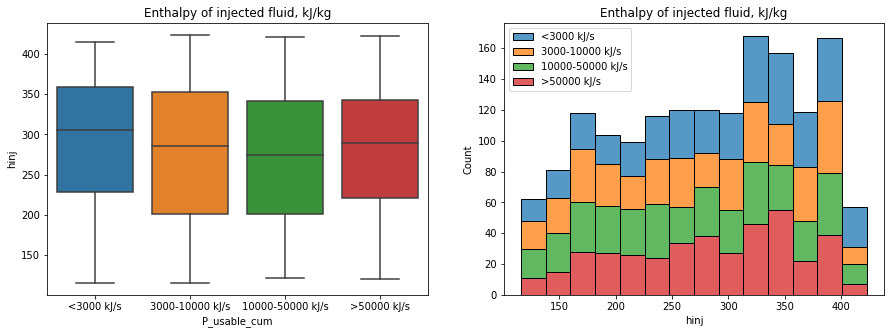

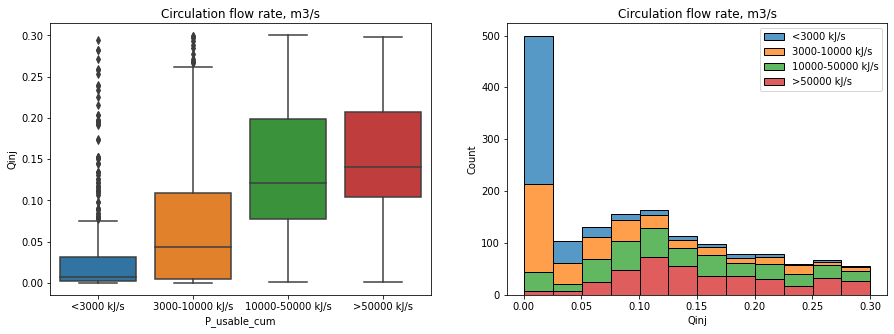

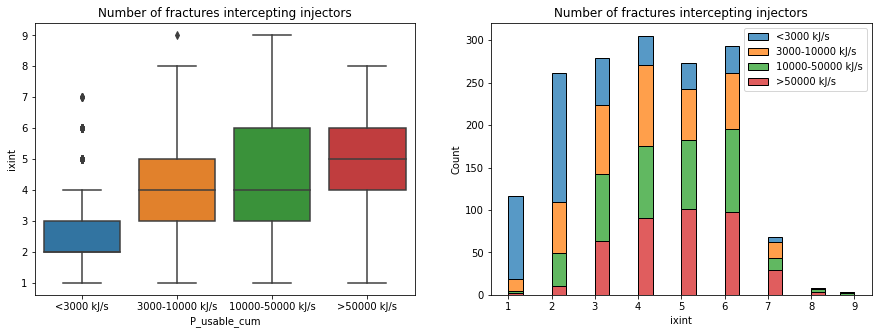

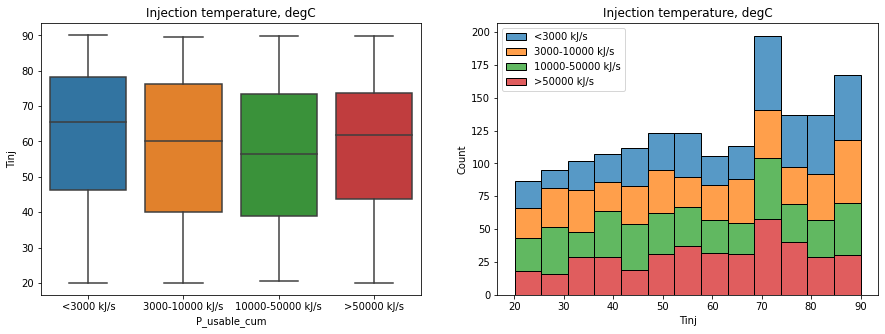

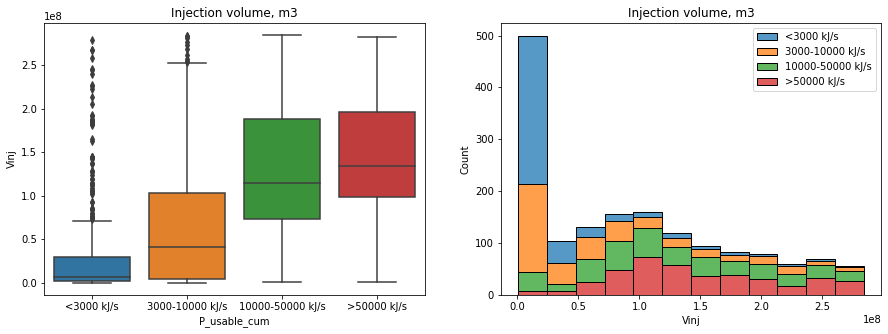

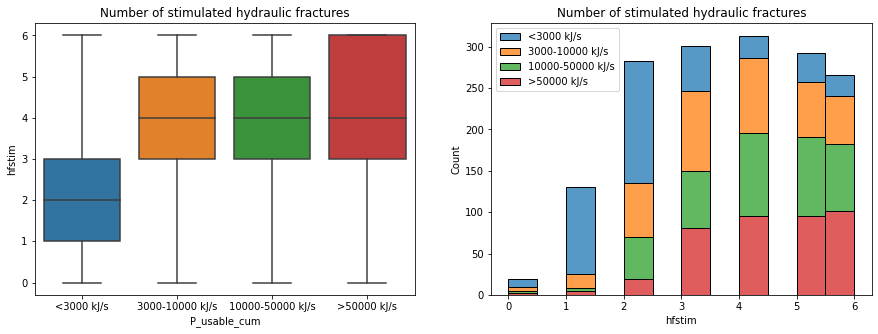

In [147]:
base_params_plots('qpro', title='Cumulative production rate, m3/s', xlim_hist=(-0.3, 0), ylim_hist=None, ylim=(-0.5, 0.1))
base_params_plots('recovery', title='Production rate/Injection rate ratio', xlim_hist=(-2, 1), ylim_hist=(0, 500), ylim=(-7, 2))
base_params_plots('w_spacing', title='Well spacing, m', xlim_hist=None, ylim_hist=None, ylim=None)
base_params_plots('qleak', title=' Boundary outflow rate, m3/s', xlim_hist=(-0.2, 0.05), ylim_hist=(0, 500), ylim=(-0.2, 0.05))
base_params_plots('r_perf', title='Perforation radus, m', xlim_hist=None, ylim_hist=None, ylim=None)
base_params_plots('nfstim', title='Number of stimulated natural fractures', xlim_hist=(0, 9), ylim_hist=None, ylim=(0, 9))
base_params_plots('dia_last', title='Final diameter of freshest fracture, m', xlim_hist=(0, 9000), ylim_hist=None, ylim=(0, 9000))
base_params_plots('hinj', title='Enthalpy of injected fluid, kJ/kg', xlim_hist=None, ylim_hist=None, ylim=None)
base_params_plots('Qinj', title='Circulation flow rate, m3/s', xlim_hist=None, ylim_hist=None, ylim=None)
base_params_plots('ixint', title='Number of fractures intercepting injectors', xlim_hist=None, ylim_hist=None, ylim=None)
base_params_plots('Tinj', title='Injection temperature, degC', xlim_hist=None, ylim_hist=None, ylim=None)
base_params_plots('Vinj', title='Injection volume, m3', xlim_hist=None, ylim_hist=None, ylim=None)
base_params_plots('hfstim', title='Number of stimulated hydraulic fractures', xlim_hist=None, ylim_hist=None, ylim=None)


# Optimal parameters actualization (1 year span)

In [ ]:
inputs_results_short1yr = pd.read_csv('datasets/inputs_results_FORGE_short1yr.csv')

inputs_results_short1yr_P_usable = inputs_results_short1yr.copy()

for time_step in range(0, 1000000, round(10000000/61)):
  inputs_results_short1yr_P_usable['P_usable'+f':{time_step/1000000:,.3f}'] = 0.13 * (inputs_results_short1yr_P_usable['dhout'+f':{time_step/1000000:,.3f}'] + (h_95C - h_120C) * inputs_results_short1yr_P_usable['mpro'])

inputs_results_short1yr_P_usable.head(3)


In [ ]:
P_usable_cum_dict = pd.DataFrame(columns=['pin', 'P_usable_cum'])

for index, row in inputs_results_short1yr_P_usable.iterrows():
  P_usable_cum = 0
  for time_step in range(0, 1000000, round(10000000/61)):
    P_usable_cum += row['P_usable'+f':{time_step/1000000:,.3f}']
  P_usable_cum_dict = P_usable_cum_dict.append({'pin': row['pin'], 'P_usable_cum': P_usable_cum}, ignore_index=True)

inputs_results_short1yr_P_usable = pd.merge(inputs_results_short1yr_P_usable, P_usable_cum_dict, on='pin')


In [ ]:
P_usable_cat1 = inputs_results_short1yr_P_usable[inputs_results_short1yr_P_usable['P_usable_cum'] < 3000]
P_usable_cat2 = inputs_results_short1yr_P_usable[inputs_results_short1yr_P_usable['P_usable_cum'].between(3000, 10000)]
P_usable_cat3 = inputs_results_short1yr_P_usable[inputs_results_short1yr_P_usable['P_usable_cum'].between(10000, 50000)]
P_usable_cat4 = inputs_results_short1yr_P_usable[inputs_results_short1yr_P_usable['P_usable_cum'] > 50000]

f, ax = plt.subplots(1, 2, figsize=(15,5))
sns.boxplot(data=pd.DataFrame({'<3000 kJ/s': P_usable_cat1['w_spacing'], '3000-10000 kJ/s': P_usable_cat2['w_spacing'],\
                               '10000-50000 kJ/s': P_usable_cat3['w_spacing'], '>50000 kJ/s': P_usable_cat4['w_spacing']}), ax=ax[0])
sns.histplot(data=pd.DataFrame({'<3000 kJ/s': P_usable_cat1['w_spacing'], '3000-10000 kJ/s': P_usable_cat2['w_spacing'],\
                               '10000-50000 kJ/s': P_usable_cat3['w_spacing'], '>50000 kJ/s': P_usable_cat4['w_spacing']}), multiple='stack', ax=ax[1])
ax[0].set(xlabel='P_usable_cum', ylabel='w_spacing')
ax[1].set(xlabel='w_spacing')

plt.show()


In [ ]:
f, ax = plt.subplots(figsize=(5,5))

sns.histplot(inputs_results_short1yr_P_usable['P_usable_cum'], ax=ax)

plt.axvline(3000, c='r')
plt.axvline(10000, c='r')
plt.axvline(50000, c='r')
plt.xlim(0, 100000)
plt.show()


In [ ]:
P_usable_cat1['P_usable_cum_cat'] = 1
P_usable_cat2['P_usable_cum_cat'] = 2
P_usable_cat3['P_usable_cum_cat'] = 3
P_usable_cat4['P_usable_cum_cat'] = 4

P_usable_cat1_2 = P_usable_cat1.append(P_usable_cat2)
P_usable_cat3_4 = P_usable_cat3.append(P_usable_cat4)

inputs_results_short1yr_P_usable_cat = P_usable_cat1_2.append(P_usable_cat3_4).sort_index()


In [ ]:
base_params_plots('qpro', title='Cumulative production rate, m3/s', xlim_hist=(-0.3, 0), ylim_hist=None, ylim=(-0.4, 0.1))
base_params_plots('recovery', title='Production rate/Injection rate ratio', xlim_hist=(-2, 1), ylim_hist=(0, 500), ylim=(-7, 2))
base_params_plots('w_spacing', title='Well spacing, m', xlim_hist=None, ylim_hist=None, ylim=None)
base_params_plots('qleak', title=' Boundary outflow rate, m3/s', xlim_hist=(-0.2, 0.05), ylim_hist=(0, 500), ylim=(-0.2, 0.05))
base_params_plots('r_perf', title='Perforation radus, m', xlim_hist=None, ylim_hist=None, ylim=None)
base_params_plots('nfstim', title='Number of stimulated natural fractures', xlim_hist=(0, 9), ylim_hist=None, ylim=(0, 9))
base_params_plots('dia_last', title='Final diameter of freshest fracture, m', xlim_hist=(0, 9000), ylim_hist=None, ylim=(0, 9000))
base_params_plots('hinj', title='Enthalpy of injected fluid, kJ/kg', xlim_hist=None, ylim_hist=None, ylim=None)
base_params_plots('Qinj', title='Circulation flow rate, m3/s', xlim_hist=None, ylim_hist=None, ylim=None)
base_params_plots('ixint', title='Number of fractures intercepting injectors', xlim_hist=None, ylim_hist=None, ylim=None)
base_params_plots('Tinj', title='Injection temperature, degC', xlim_hist=None, ylim_hist=None, ylim=None)
base_params_plots('Vinj', title='Injection volume, m3', xlim_hist=None, ylim_hist=None, ylim=None)
base_params_plots('hfstim', title='Number of stimulated hydraulic fractures', xlim_hist=None, ylim_hist=None, ylim=None)


In [ ]:
P30 = inputs_results_main30yr_P_usable_loss['P_usable_cum']
P20 = inputs_results_medium20yr_P_usable['P_usable_cum']
P1 = inputs_results_short1yr_P_usable['P_usable_cum']

f, ax = plt.subplots(1, 1, figsize=(5,8))
sns.boxplot(data=pd.DataFrame({'P30': P30, 'P20': P20, 'P1': P1}), ax=ax)

ax.set(xlabel='w_spacing', ylim=(-50000, 100000))

plt.show()


### Next steps:
* try categories by P_usable
* try categories by P_usable_loss
* try categories by P_out
* hist/bp in P_usable_cat, P_usable_loss_cut, P_out_cat
* get 3D simulations based on optimal parameters